# Gap creation rate
Inspired from Carlberg et al 2012 

$$ R(r) = \int _M \int _{v_\perp} \int_{0}^{b_{\textrm{max}}} n(r) N(M) v_\perp f(v_\perp) \pi db dv_\perp dM$$ 

for me, I am doing something numerical! so my result is:

$$ R_{\textrm{Pal 5}} =  \frac{1}{T}\int_{0}^T \mathcal{l}^{-1}(t) \sum_i \delta(t-t_i) dt$$

The delta function is zero everywhere except at $t_i$ which is the time at which the impacts occur. $\mathcal{l}$ is the length of the stream, and $T$ is the total integration time. Therefore, for a given simulation:

$$ R_{j,\textrm{Pal 5}} =  \frac{1}{T} \sum_i \frac{1}{l (t_i)}$$


And then we look at the distribution of R for all the simulations: 

$$ \langle R_{\textrm{Pal 5}}\rangle = \textrm{Mean}(R_{j,\textrm{Pal 5}}) $$

In [225]:
import stream_analysis as sa
from gcs import path_handler as ph 
import h5py
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gcs
import astropy.units as u

In [213]:
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use 'serif' or specify the exact font family
    "font.serif": ["Times New Roman"],  # Replace with the font used in your LaTeX document
    "axes.labelsize": 12,  # Font size for axis labels
    "font.size": 12,  # General font size
    "legend.fontsize": 12,  # Font size for legend
    "xtick.labelsize": 12,  # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
})

# Set data parameters

In [172]:
internal_dynamics   =   "isotropic-plummer"
NP                  =   int(1e5)
MWpotential         =   "pouliasis2017pii-GCNBody"
GCname              =   "Pal5"

# hyper parameter
threshold = 100 # for the stream density, minimum number of counts

# Load the gap results

In [173]:
results_path=ph.paths['simulations'] + "/ImpactGeometry/pouliasis2017pii-GCNBody/Pal5"+"/AllImpactGeometryByHandAndEye.csv"
results = pd.read_csv(results_path)
withgap=results[results['gap_flag']]

initialize the output array for the stream length of each simulation


In [218]:
nmontecarlo = np.unique(results['montecarlokey'].to_numpy()).shape[0]
gapCreationRate = np.zeros(nmontecarlo)

In [219]:
# iterate over the monte-carlo-keys to extract when the gaps occured
for i in range(nmontecarlo):
    montecarlokey = "monte-carlo-"+str(i).zfill(3)
    criteria = withgap["montecarlokey"]==montecarlokey
    # only compute if a gap exists
    if criteria.any():
        print(montecarlokey, "has", withgap[criteria].shape[0], "gaps")
        # get the subset of the results
        subset = withgap[criteria]
        # load the stream length
        fileTauPath  = ph.tauDensityMaps(GCname=GCname,MWpotential=MWpotential,montecarlokey=montecarlokey,NP=NP,internal_dynamics=internal_dynamics)
        # extract the gap length from the denisty profile
        tau_centers,time_stamps,tau_counts = sa.identify_suspects.extract_tau_stream_density(fileTauPath)
        leftindexes,rightindexes=sa.streamLength.get_envelop_indexes(tau_counts,threshold)
        tau_left,tau_right=sa.streamLength.tau_envelopes(tau_centers,leftindexes,rightindexes)
        # Extract the orbit 
        GCorbitspath=ph.GC_orbits(MWpotential=MWpotential,GCname=GCname)
        tGC,xGC,yGC,zGC,vxGC,vyGC,vzGC=gcs.extractors.GCOrbits.extract_whole_orbit(GCorbitspath,montecarlokey)
        # set the total integration time that was used
        T = -tGC[0]
        # initialize the gap loop
        ngaps = subset.shape[0]
        ls = np.zeros(ngaps)   
        # loop over the gaps 
        for j in range(ngaps):
            # get the time indexes
            impact_time = subset['T'].iloc[j]
            time_index_profile = np.argmin(np.abs(impact_time-time_stamps))
            my_tau_left = tau_left[time_index_profile]
            my_tau_right = tau_right[time_index_profile]

            # match the time indexes
            time_index_orbit = np.argmin(np.abs(tGC-impact_time))
            left_time_index_orbit = np.argmin(np.abs(tGC-(impact_time+my_tau_left)))
            right_time_index_orbit = np.argmin(np.abs(tGC-(impact_time+my_tau_right)))
            # do the numeric line integral
            dxs=np.diff(xGC[left_time_index_orbit:right_time_index_orbit])
            dys=np.diff(yGC[left_time_index_orbit:right_time_index_orbit])
            dzs=np.diff(zGC[left_time_index_orbit:right_time_index_orbit])
            ds=np.sqrt(dxs**2+dys**2+dzs**2)
            ls[j] = np.sum(ds)
        gapCreationRate[i]=np.sum(1/ls)/T  

monte-carlo-000 has 3 gaps
monte-carlo-001 has 1 gaps
monte-carlo-002 has 1 gaps
monte-carlo-003 has 1 gaps
monte-carlo-004 has 1 gaps
monte-carlo-005 has 2 gaps
monte-carlo-006 has 2 gaps
monte-carlo-007 has 2 gaps
monte-carlo-008 has 1 gaps
monte-carlo-009 has 3 gaps
monte-carlo-010 has 1 gaps
monte-carlo-011 has 2 gaps
monte-carlo-012 has 1 gaps
monte-carlo-013 has 1 gaps
monte-carlo-014 has 2 gaps
monte-carlo-015 has 1 gaps
monte-carlo-016 has 1 gaps
monte-carlo-017 has 1 gaps
monte-carlo-019 has 2 gaps
monte-carlo-020 has 1 gaps
monte-carlo-021 has 1 gaps
monte-carlo-022 has 2 gaps
monte-carlo-023 has 1 gaps
monte-carlo-024 has 2 gaps
monte-carlo-025 has 2 gaps
monte-carlo-026 has 2 gaps
monte-carlo-027 has 3 gaps
monte-carlo-028 has 2 gaps
monte-carlo-029 has 1 gaps
monte-carlo-030 has 2 gaps
monte-carlo-032 has 1 gaps
monte-carlo-033 has 4 gaps
monte-carlo-034 has 1 gaps
monte-carlo-035 has 2 gaps
monte-carlo-036 has 1 gaps
monte-carlo-037 has 1 gaps
monte-carlo-038 has 1 gaps
m

In [277]:
nbins = int ( np.ceil ( np.sqrt(nmontecarlo) ) )
std = np.std(gapCreationRate)
bins = np.linspace(0,gapCreationRate.max()+std/10,2*nbins)
counts, bins = np.histogram(gapCreationRate,bins=bins)
centers = (bins[:-1] + bins[1:]) / 2
mode = centers[counts.argmax()]
first_quartile = np.percentile(gapCreationRate, 25)
third_quartile = np.percentile(gapCreationRate, 75)

np.float64(0.01848921673148334)

In [290]:
# gap creation rate units
unitL = u.kpc
unitV = u.km/u.s
unitT = unitL/unitV
unitGapCreationRate = unitT**(-1) * unitL**(-1)


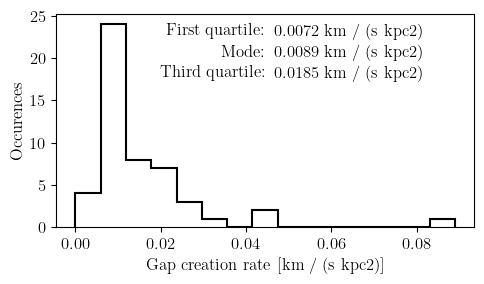

In [315]:
from matplotlib.font_manager import FontProperties

fig,axis = plt.subplots(figsize=(5,3))
axis.hist(gapCreationRate,bins=bins,edgecolor='black',histtype='step',linewidth=1.5)
axis.set_xlabel("Gap creation rate [{:s}]".format(unitGapCreationRate.to_string()))
axis.set_ylabel("Occurences")
label_width = 2
value_width = 10
# monospace_font = {'family': 'monospace', 'fontsize': 10}
monospace_font = FontProperties(family='Courier New', size=10)


label_first = "{:<{label_width}}:".format("First quartile", label_width=label_width)
value_first = "{:>{value_width}.4f} {:s}".format(first_quartile, unitGapCreationRate, value_width=value_width)

label_mode = "{:<{label_width}}:".format("Mode", label_width=label_width)
value_mode = "{:>{value_width}.4f} {:s}".format(mode, unitGapCreationRate, value_width=value_width)

label_third = "{:<{label_width}}:".format("Third quartile", label_width=label_width)
value_third = "{:>{value_width}.4f} {:s}".format(third_quartile, unitGapCreationRate, value_width=value_width)

# Place the text on the plot
axis.text(0.50, 0.90, label_first, transform=axis.transAxes, ha='right')
axis.text(0.52, 0.90, value_first, transform=axis.transAxes, ha='left')

axis.text(0.50, 0.80, label_mode, transform=axis.transAxes, ha='right')
axis.text(0.52, 0.80, value_mode, transform=axis.transAxes, ha='left')

axis.text(0.50, 0.70, label_third, transform=axis.transAxes, ha='right')
axis.text(0.52, 0.70, value_third, transform=axis.transAxes, ha='left')

fig.tight_layout()
fig.savefig("../paper/gap_creation_rate.png",dpi=300)


In [313]:
72/5.1/50/20

0.014117647058823532

In [314]:
np.mean(gapCreationRate)

np.float64(0.014721433488432346)